In [25]:
#Charger le repertoire des scripts
import sys
import os
sys.path.append(os.path.abspath('./Library'))
import numpy as np
from matplotlib.pyplot import close, show
import matplotlib.pyplot as plt
import xarray as xr
from reef_models import reef_platform, reef, reef_eros
from tools import nlines
from tools_models import CheckSimu, ZarrName, shore
from Profile import Profile
from Dicts import Dicos
from datetime import datetime as dtime
from os import path
import xsimlab as xs
from Dict_models import DicoModels
# to download xsimlab : pip install xarray-simlab


## Model input dataset

In [11]:
# %create_setup -v reef

dt = 400 # You can go up to 400 for detailed long simu, for a quick view, up to 1000
dico = Dicos()

# The first relevant parameters to test are : vertical__u, construct__Gm, hfactor__Dbar, eros__Ev.
# Remove the platform for the first tests I think, but if you prefer with one go ahead ! When you better see how the 4 
# parameters works, you can try another one, and bit by bit explore everything. If you want, at the end you can try also 
# to test "hfactor__how". But do not change the values of the other parameters in the "no need to test" part.

#SL = 'Bintanja2008-1000k.dat'
#SL = 'Waelbroeck2002-137ky.dat'
# SL = 'Waelbroeck2002b.dat'
SL = 'Holocene-SL.dat'
SL = 'Grant2014-1000ky.dat'
#SL = 'Bintanja2005.dat'
tmax = nlines(dico.path_SLcurves+SL)*1e3
print(tmax)

ds_in = xs.create_setup(
    model=reef,
    clocks={
        'time' : np.arange(0., tmax+dt, dt),
},
    master_clock = 'time',
    input_vars={
        ## Usefull parameters to test. Everything in meters and years.
        # vertical land motion rate. [-10 - 2]e-3 (huge values, you can test before with 0.something e-3)
        'vertical__u': 0.5e-3,
        # initial slope of the substrate. [2 - 8]
        'grid__slopi': 6e-2,
        # maximum reef growth rate. [2 - 15]
        'construct__Gm': 6e-3,
        # maximum water height for reef growth. [10 - 50] 
        'construct__hmax':20,
        # width of wave action (controls the width of the coral reef). [10 - 3000] 
        'hfactor__Dbar': 100,
        # Eroded volume. [50 - 1000]e-3
        'eros__Ev': 60e-3,
        # Water height for wave base (the waves will start to erode at this depth). [1 - 10]
        'eros__hwb': 3.,
        ## No need to test 
        # Water height for open ocean
        'hfactor__how': 2,
        # uniform spacing
        'grid__spacing': 1,
        # filename for RSL reconstruction
        'SLstory__RSLin': SL,
        # I don't know.... 
        'grid__dmax': 20,
        # Coefficient for erosion efficiency, sea-bed
        'eros__beta1': 0.1,
        # Coefficient for erosion efficiency, cliff retreat
        'eros__beta2': 1,
        # Height of notch for volume eroded during cliff retreat
        'eros__hnotch': 1,
        # ---
        'depot__repos': 15e-2,
    },
#     output_vars={
#         'init__x'       : None,
#         'profile__z'    : 'time',
#         'sealevel__asl' : 'time',
#         'profile__xmin' : None,
#         'profile__xmax' : None,
#         'depot__dS'     : 'time',
#         'construct__dG' : 'time',
#     }
# )

    output_vars={
        'init__x'       : None,
        'profile__z'    : None,
        'sealevel__asl' : None,
        'profile__xmin' : None,
        'profile__xmax' : None,
    }
)

### The second set of outputs, with all set to "None", is to compute only the last profile. See below.


ds_in.attrs['model_name'] = 'reef'
ds_in.attrs['store'] = 'Profile'

1001000.0


In [31]:
class REEF:
    
    def __init__(self):
        # Define the fixed parameters
        self.input_vars = {
            # Water height for open ocean
            'hfactor__how': 2,
            # uniform spacing
            'grid__spacing': 1,
            # Grid width factor. Should be similar to hmax 
            'grid__dmax': 20,
            # Coefficient for erosion efficiency, sea-bed
            'eros__beta1': 0.1,
            # Coefficient for erosion efficiency, cliff retreat
            'eros__beta2': 1,
            # Height of notch for volume eroded during cliff retreat
            'eros__hnotch': 1,
            # Repos angle
            'depot__repos': 15e-2,
        }
    
    def reef_params(self, SL, U, slop, Gm, Ev, hmax=20, Dbar=100, hwb=3.):
        # Complete the dictionnary of fixed parameters with the ones to test
        self.input_vars.update({
            ## Usefull parameters to test. Everything in meters and years.
            # filename for RSL reconstruction
            'SLstory__RSLin': SL,
            # vertical land motion rate. [-10 - 2]e-3 (huge values, you can test before with 0.something e-3)
            'vertical__u': U,
            # initial slope of the substrate. [2 - 8]
            'grid__slopi': slop,
            # maximum reef growth rate. [2 - 15]
            'construct__Gm': Gm,            
            # Eroded volume. [50 - 1000]e-3
            'eros__Ev': Ev,
            # maximum water height for reef growth. [10 - 50] 
            'construct__hmax': hmax,
            # width of wave action (controls the width of the coral reef). [10 - 3000] 
            'hfactor__Dbar': Dbar,
            # Water height for wave base (the waves will start to erode at this depth). [1 - 10]
            'eros__hwb': float(hwb),
        })
        
    def run(self, dt, save):
        self.save = save
        dico = Dicos()
        # Define the output of the model
        if save==True:
            output = {
                'init__x'       : None,
                'profile__z'    : 'time',
                'sealevel__asl' : 'time',
                'profile__xmin' : None,
                'profile__xmax' : None,
                'depot__dS'     : 'time',
                'construct__dG' : 'time',
            }
        elif save==False:
            output={
                'init__x'       : None,
                'profile__z'    : None,
                'sealevel__asl' : None,
                'profile__xmin' : None,
                'profile__xmax' : None,
            }
        else:
            raise("Wrong format for 'save' variable. Should be True or False")

        tmax = nlines(dico.path_SLcurves+self.input_vars['SLstory__RSLin'])*1e3
        # Create xsimlab setup
        ds_in = xs.create_setup(
            model=reef,
            clocks={'time' : np.arange(0., tmax+dt, dt)},
            master_clock = 'time',
            input_vars = self.input_vars,
            output_vars = output
        )
        ds_in.attrs['model_name'] = 'reef'
        ds_in.attrs['store'] = 'Profile'

        # Run the model
        t0=dtime.today()
        dm   = DicoModels()
        with dm.models[ds_in.model_name]:
            self.ds_out = (ds_in   
              .xsimlab.run()
                  )
        print('Duration', dtime.today()-t0)

    def plot(self):
        if self.save==True:
            print('Starting plot')
            fig = Profile(self.ds_out)
            fig.ProfileName('.png')
            fig.PlotProfile()
            fig.PlotASL()
            fig.WriteParams()
            fig.Savefig()
            show()
            close('all')
        elif self.save==False:
            plt.plot(ds_out.profile__z)
        else:
            raise("Wrong format for 'layers' variable. Should be True or False")
        
            

In [32]:
REEF = REEF()
REEF.reef_params(SL='Holocene-SL.dat',
                U = 0.5e-3,
                slop = 6e-2,
                Gm = 6e-3,
                Ev= 60e-3)

In [35]:
REEF.run(200, True)


/srv/conda/envs/notebook/lib/python3.10/site-packages/xsimlab/drivers.py:338: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for step, (_, ds_step) in enumerate(ds_gby_steps):


t 0.0
Duration 0:00:01.389001


Starting plot
WORK !!!


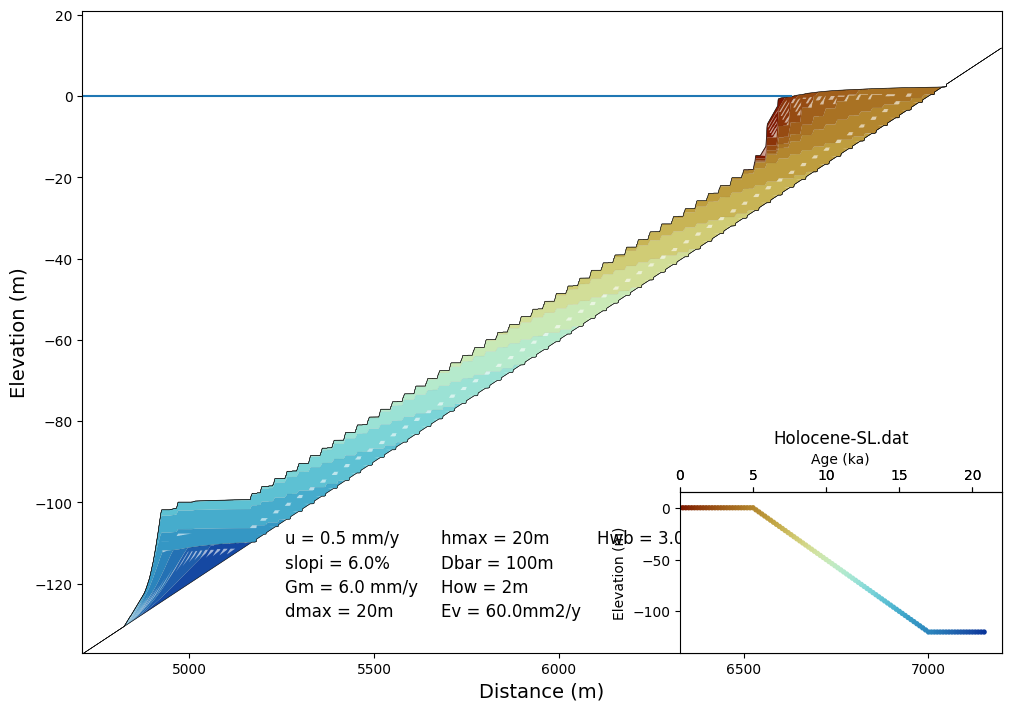

In [36]:
REEF.plot()

# Run

In [3]:
# Code to compute and plot at each time step
              
t0=dtime.today()
print(t0)

# Running the simulation if it doesn't exist
if CheckSimu(ds_in, simu=True, view=True):
    ds = xr.open_zarr(ZarrName(ds_in))

    # Plotting figure
    fig = Profile(ds)
    fig.ProfileName('.png')

#                             # If the figure already exists, skip the iteration
    if path.exists(fig.namepath+fig.namefig):
        print('Done')
        close('all')

    fig.PlotProfile()
#                             fig.PlotData('DemoProfil.txt')
    fig.PlotASL()
    fig.WriteParams()

    print('save')
    fig.Savefig()
    show()
    close('all')
    print('Duration', dtime.today()-t0)


2024-10-04 08:33:02.678699
reef
./Outs/Zarr/Profiles/reef/reef_Profile_Holocene-SL.dat-u0.5-slopi6.0-Gm6.0-dmax20-hmax20-Dbar100-How2-Ev60.0-Hwb3.0-tmax21ky-dt1000y.zarr
reef
Done
WORK !!!
save
Duration 0:00:03.045957


In [12]:
### Run cell to compute only the last profile (with outputs on "None,None,None...")

from Dict_models import DicoModels

t0=dtime.today()

dm   = DicoModels()
with dm.models[ds_in.model_name]:
    ds_out = (ds_in   
      .xsimlab.run()
          )
print('Duration', dtime.today()-t0)


t 0.0
t 100.0
t 200.0
t 300.0
t 400.0
t 500.0
t 600.0
t 700.0
t 800.0
t 900.0
t 1000.0
Duration 0:00:10.798239


(-200.0, 500.0)

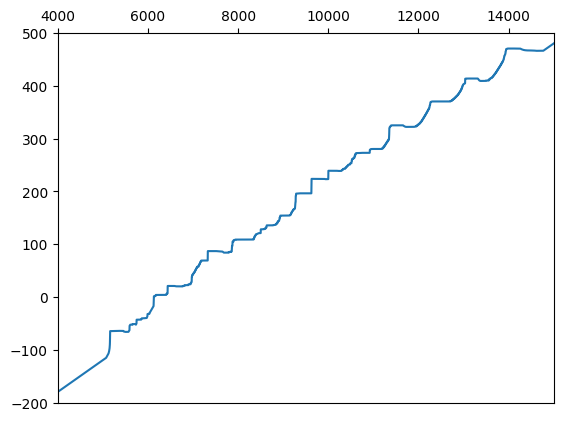

In [13]:
### Plot the last profile, run the cell above firstly

plt.plot(ds_out.profile__z)

# # To zoom on the profile. First, let this commented, plot the profile and check where to zoom.
plt.xlim(4000,15000)
plt.ylim(-200,500)

In [6]:
ds_out


<xarray.Dataset>
Dimensions:          (time: 22, x: 21508)
Coordinates:
  * time             (time) float64 0.0 1e+03 2e+03 ... 1.9e+04 2e+04 2.1e+04
  * x                (x) float64 0.0 1.0 2.0 ... 2.15e+04 2.151e+04 2.151e+04
Data variables: (12/22)
    SLstory__RSLin   <U15 'Holocene-SL.dat'
    construct__Gm    float64 0.006
    construct__dG    (time, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    construct__hmax  int64 20
    depot__dS        (time, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    depot__repos     float64 0.15
    ...               ...
    init__x          (x) float64 0.0 1.0 2.0 ... 2.15e+04 2.151e+04 2.151e+04
    profile__xmax    float64 6.989e+03
    profile__xmin    float64 4.81e+03
    profile__z       (time, x) float64 -430.5 -430.4 -430.4 ... 870.4 870.4
    sealevel__asl    (time) float64 -120.0 -120.0 -120.0 -120.0 ... 0.0 0.0 0.0
    vertical__u      float64 0.0005
Attributes:
    model_name:  reef
    store:       Profile